In [1]:
from datetime import datetime, timedelta
import bz2
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from intervaltree import IntervalTree, Interval
from iso8601 import parse_date

from satbazaar import db

In [2]:
mpl.rcParams['font.size'] = 14

In [3]:
# script 'get-observations.py' generates this file
observations = db.load_observations()

In [4]:
tree = IntervalTree()

# count the bad obs start/end times
non_causal = 0
zero_duration = 0
for o in observations.values():
    start = parse_date(o['start'], default_timezone=None)
    end = parse_date(o['end'], default_timezone=None)
    
    # ignore bogus start/end times
    if end < start:
        non_causal += 1
        continue
    elif end == start:
        zero_duration += 1
        continue
    tree.addi(start, end, o)

print(zero_duration, 'zero duration')
print(non_causal, 'start > end')

69 zero duration
77 start > end


In [5]:
len(tree)

309560

In [6]:
firstday = tree.begin().replace(hour=0, minute=0, second=0)
lastday = tree.end().replace(hour=0, minute=0, second=0)


days = [firstday + timedelta(days=i) for i in range(0, (lastday - firstday).days, 1)]
print(firstday)
print(lastday)
len(days)

2015-10-12 00:00:00+00:00
2018-11-22 00:00:00+00:00


1137

In [7]:
def analyze_tree(tree):
    total = []
    good = []
    bad = []
    failed = []
    unknown = []
    duration = []
    actives = []

    oneday = timedelta(days=1)
    for i, day in enumerate(days):
        obs = IntervalTree(tree[day : day + oneday])
        
        # trim the obs
        obs.chop(day + oneday, obs.end(), lambda x,y:x.data)
        obs.chop(obs.begin(), day, lambda x,y:x.data)

        count = dict(total=0, good=0, bad=0, failed=0, unknown=0)
        active = set()
        d = timedelta(seconds=0)
        for o in obs:
            count[o.data['vetted_status']] += 1
            count['total'] += 1
            d += o.end - o.begin
            active.add(o.data['ground_station'])
        total.append(count['total'])
        good.append(count['good'])
        bad.append(count['bad'])
        failed.append(count['failed'])
        unknown.append(count['unknown'])
        duration.append(d)
        actives.append(len(active))

    return total, good, bad, failed, unknown, duration, actives

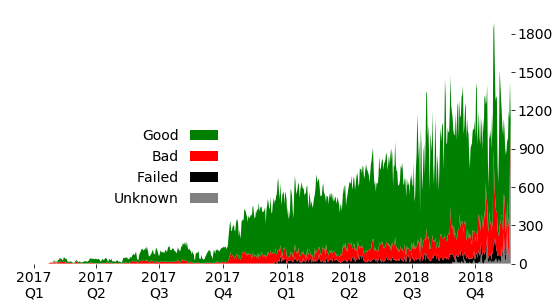

In [8]:
total, good, bad, failed, unknown, duration, actives = analyze_tree(tree)

fig, ax = plt.subplots(figsize=(8, 4.5))

lines = ax.stackplot(
    days,
    (unknown, failed, bad, good),
    labels=reversed(('Good', 'Bad', 'Failed', 'Unknown')),
    colors=('grey', 'k', 'r', 'g'),
)

# stackplot reverses the legend order :(
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    loc='lower right',
    bbox_to_anchor=(0.4, 0.2),
    frameon=False,
    markerfirst=False,
    borderpad=0,
)

ax.set_xlim(left=datetime(2017, 1, 1), right=days[-1])



def quarter_formatter(x, pos):
    d = mpl.dates.num2date(x)
    q = ((d.month - 1) // 3) + 1
    if True: #q % 2 == 1:
        s = '  {}  \nQ{}'.format(d.year, q)
    else:
        s = ''
    return s

ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1, 4, 7, 10)))

#ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=0, ha='center', va='top')

ax.yaxis.tick_right()
ax.set_yticks(range(0, 2100, 300))
ax.set_ylim(bottom=0)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

fig.savefig('network-obs-day.png', dpi=300)

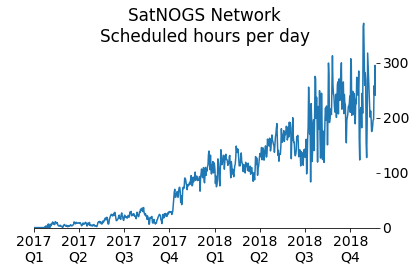

In [9]:
fig, ax = plt.subplots()

access = np.fromiter((d.total_seconds() for d in duration), np.float, len(duration))

ax.plot(days, access/(60*60))

ax.set_title(
    'SatNOGS Network\nScheduled hours per day',
    va='top',
)

fig.autofmt_xdate()
ax.set_xlim(
    left=datetime(2017, 1, 1),
    right=days[-1],
)

ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1, 4, 7, 10)))

#ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=0, ha='center', va='top')

ax.yaxis.tick_right()
ax.set_ylim(bottom=0)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

plt.tight_layout()

#fig.savefig('network-obs-access.png', dpi=150)

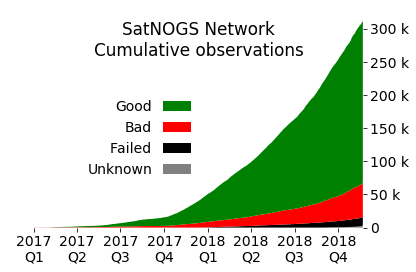

In [10]:
fig, ax = plt.subplots()

lines = ax.stackplot(
    days,
    (np.cumsum(unknown), np.cumsum(failed), np.cumsum(bad), np.cumsum(good)),
    labels=reversed(('Good', 'Bad', 'Failed', 'Unknown')),
    colors=('grey', 'k', 'r', 'g'),
)

ax.set_title(
    'SatNOGS Network\nCumulative observations',
    va='top',
    #ha='left',
    #loc='left',
    pad=-10,
)

# stackplot reverses the legend order :(
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    labels[::-1],
    loc='lower right',
    bbox_to_anchor=(0.5, 0.2),
    frameon=False,
    markerfirst=False,
    borderpad=0,
)

ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1, 4, 7, 10)))

#ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=0, ha='center')

ax.set_xlim(left=datetime(2017, 1, 1), right=days[-1])

ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter())
ax.yaxis.tick_right()
ax.set_ylim(bottom=0)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()

#fig.savefig('network-obs-day.png', dpi=150)

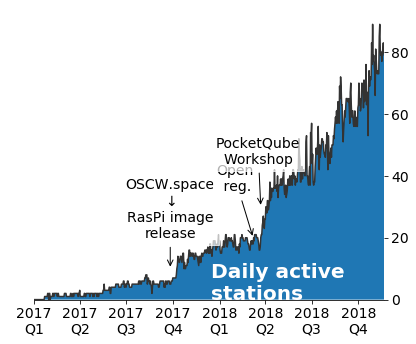

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))

actives = np.array(actives)

ax.plot(days, actives, color='#333333')

ax.text(datetime(2017, 12, 15), 12,
        'Daily active\nstations',
        va='top',
        ha='left',
        fontsize='x-large',
        color='white',
        weight='semibold',
)

ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1, 4, 7, 10)))

#ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

labels = ax.get_xticklabels()
plt.setp(labels, rotation=0, ha='center', va='top',)
#        bbox=dict(facecolor='#cadaf2',
#                  edgecolor='#cadaf2'),
#)


ax.set_xlim(
    left=datetime(2017, 1, 1),
    right=days[-1],
)

ax.yaxis.tick_right()
ax.set_ylim(bottom=0)

labels = ax.get_yticklabels()
#plt.setp(labels,
#        bbox=dict(facecolor='#cadaf2',
#                  edgecolor='#cadaf2'),
#)

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

xy = list(zip([mpl.dates.date2num(d) for d in days], actives))
xy.insert(0, (ax.get_xlim()[0]-10, 0))
xy.append((ax.get_xlim()[1], 0))
path = mpl.path.Path(xy)
patch = mpl.patches.PathPatch(path, facecolor='#1f77b4', edgecolor='none')  # '#cadaf2'  '#1f77b4'
ax.add_patch(patch)


bbprops = dict(facecolor='white', edgecolor='white', alpha=0.7)

ax.annotate(
    'OSCW.space\n$\downarrow$\nRasPi image\nrelease',
    (datetime(2017, 9, 26), 10),
    xytext=(datetime(2017, 9, 26), 20),
    ha='center',
    size='medium',
    arrowprops=dict(arrowstyle='->'),
    bbox=bbprops,
)


if False:
    ax.annotate(
        'FOSDEM',
        (datetime(2018, 2, 4), 20),
        xytext=(datetime(2018, 2, 1), 27),
        ha='center',
        size='medium',
        arrowprops=dict(arrowstyle='->'),
    )

ax.annotate(
    'Open\n reg.',
    (datetime(2018, 3, 8), 20),
    xytext=(datetime(2018, 2, 1), 35),
    ha='center',
    size='medium',
    arrowprops=dict(arrowstyle='->'),
    bbox=bbprops,
)

ax.annotate(
    'PocketQube\nWorkshop',
    (datetime(2018, 3, 23), 30),
    xytext=(datetime(2018, 3, 18), 44),
    ha='center',
    size='medium',
    arrowprops=dict(arrowstyle='->'),
    bbox=bbprops,
)


plt.tight_layout()

fig.savefig('network-active-stations.png', dpi=600, transparent=True)

In [12]:
# compute access time per gs

from collections import defaultdict
gstree = defaultdict(IntervalTree)

for i in tree:
    gs = i.data['ground_station']
    if gs is None:
        continue
    gstree[gs].add(i)

for gs in gstree:
    results = analyze_tree(gstree[gs])
    total, good, bad, failed, unknown, duration, actives = results
    for i in gstree[gs]:
        gstree[gs].gsname = i.data['station_name']
        break

    gstree[gs].id = gs
    gstree[gs].total = total
    gstree[gs].good = good
    gstree[gs].bad = bad
    gstree[gs].failed = failed
    gstree[gs].unknown = unknown
    gstree[gs].duration = duration

maxpasses = np.max([s.total for s in gstree.values()])

In [13]:
print(maxpasses)

116


In [14]:
def quarter_formatter(x, pos):
    d = mpl.dates.num2date(x)
    q = ((d.month - 1) // 3) + 1
    if q % 4 == 1:
        s = '{}'.format(d.year)
    else:
        s = ''
    return s

def plot_status(gs, ax):
    #fig, ax = plt.subplots(figsize=(8, 4.5))

    lines = ax.stackplot(
        days,
        (gs.unknown, gs.failed, gs.bad, gs.good),
        labels=reversed(('Good', 'Bad', 'Failed', 'Unknown')),
        colors=('grey', 'k', 'r', 'g'),
    )

    ax.set_xlim(left=datetime(2017, 1, 1), right=days[-1])

    ax.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=(1, 4, 7, 10)))

    #ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(quarter_formatter))

    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=0, ha='center', va='top')

    #ax.yaxis.tick_right()
    #ax.yaxis.set_label_position('right')
    ax.set_yticks([0])
    ax.set_yticklabels([''])
    #ax.set_ylim(bottom=0)
    #ax.set_ylabel('Passes', rotation=0, labelpad=20)

    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    


218

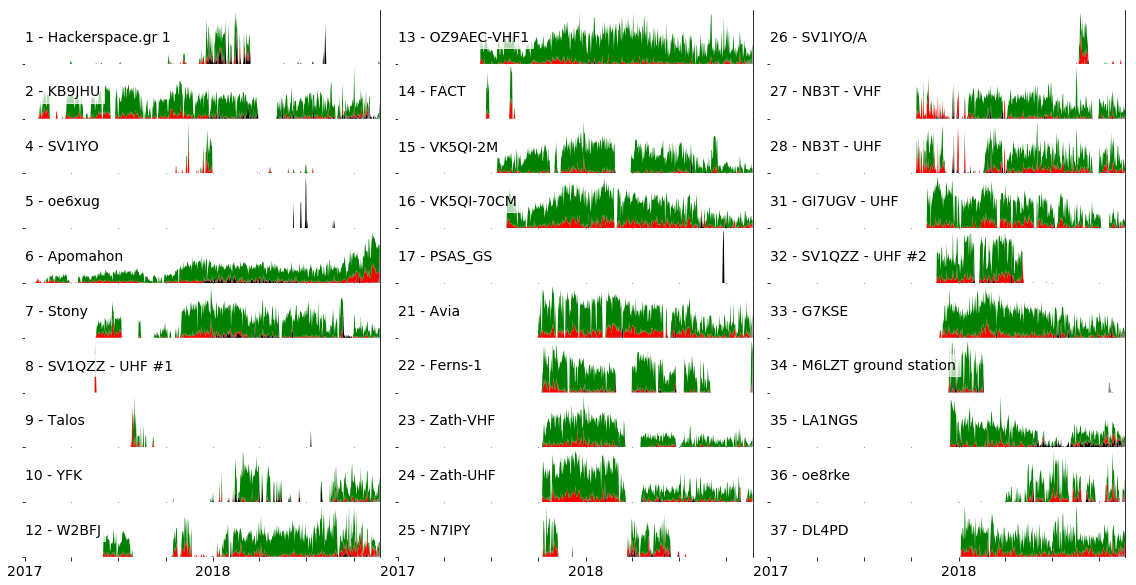

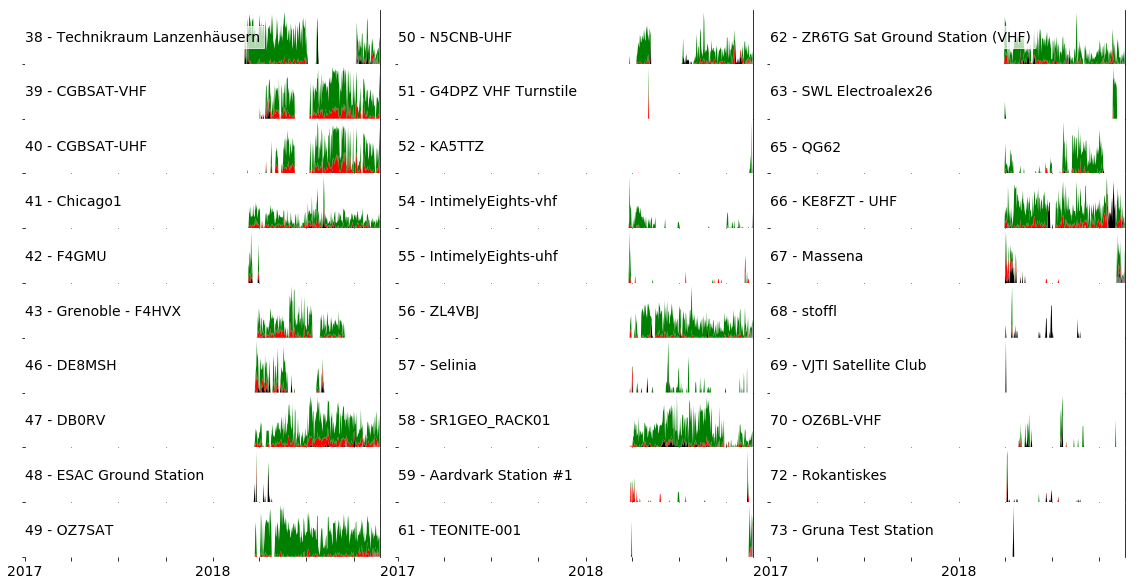

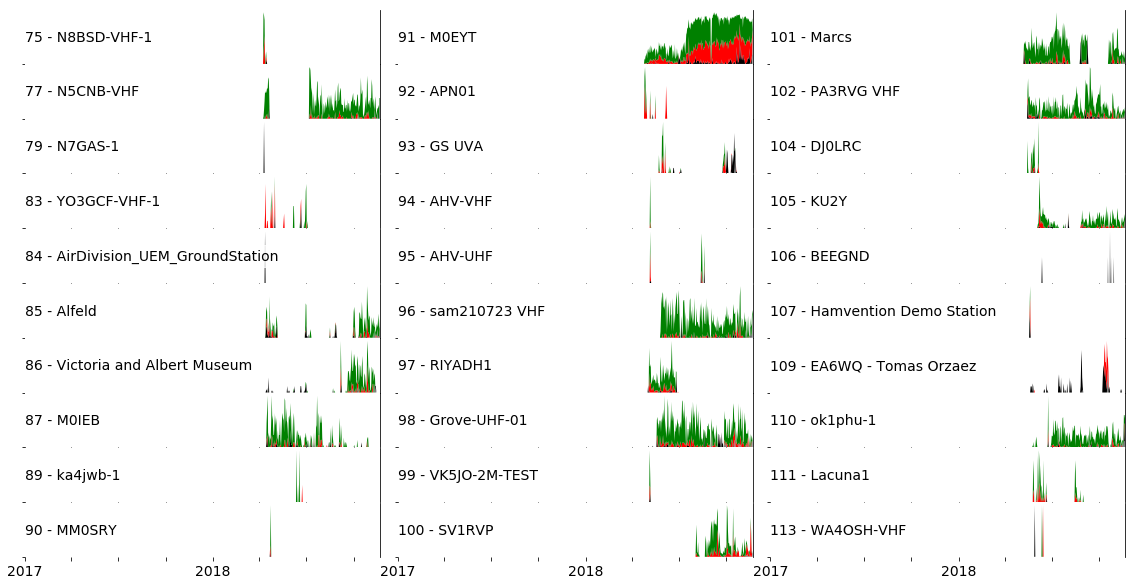

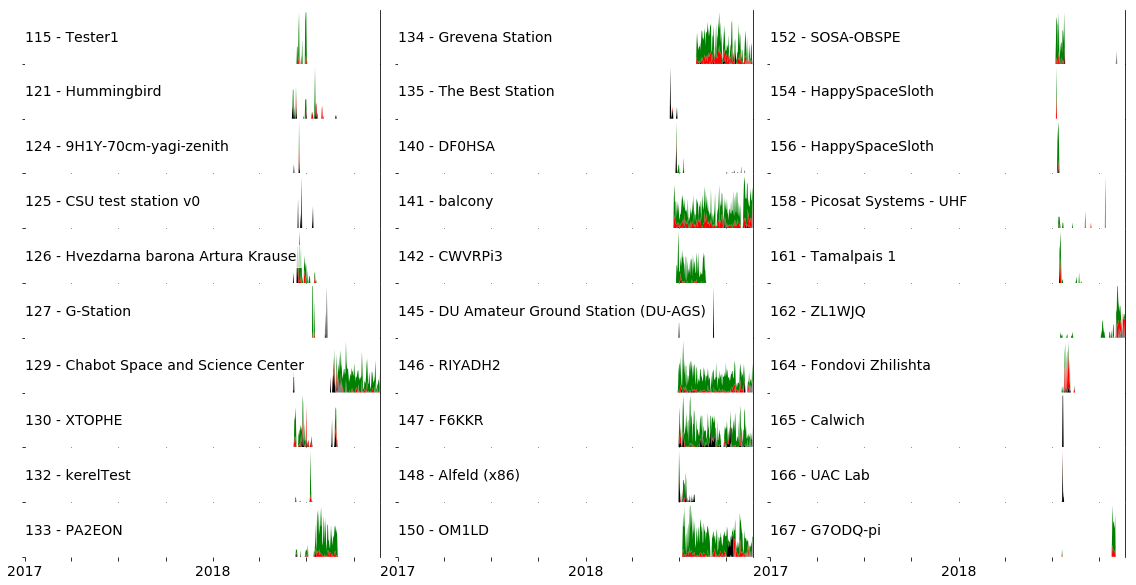

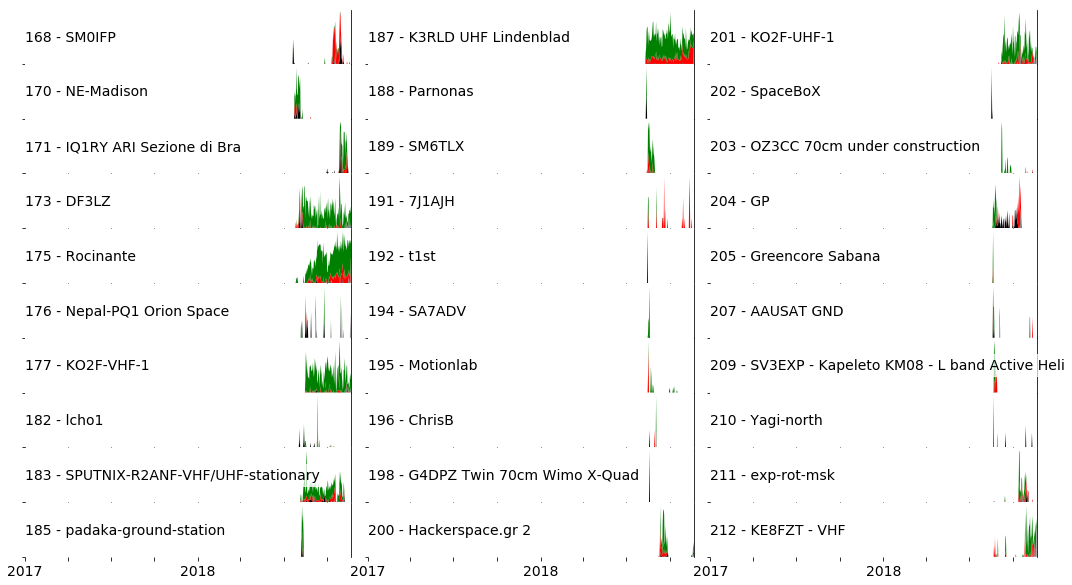

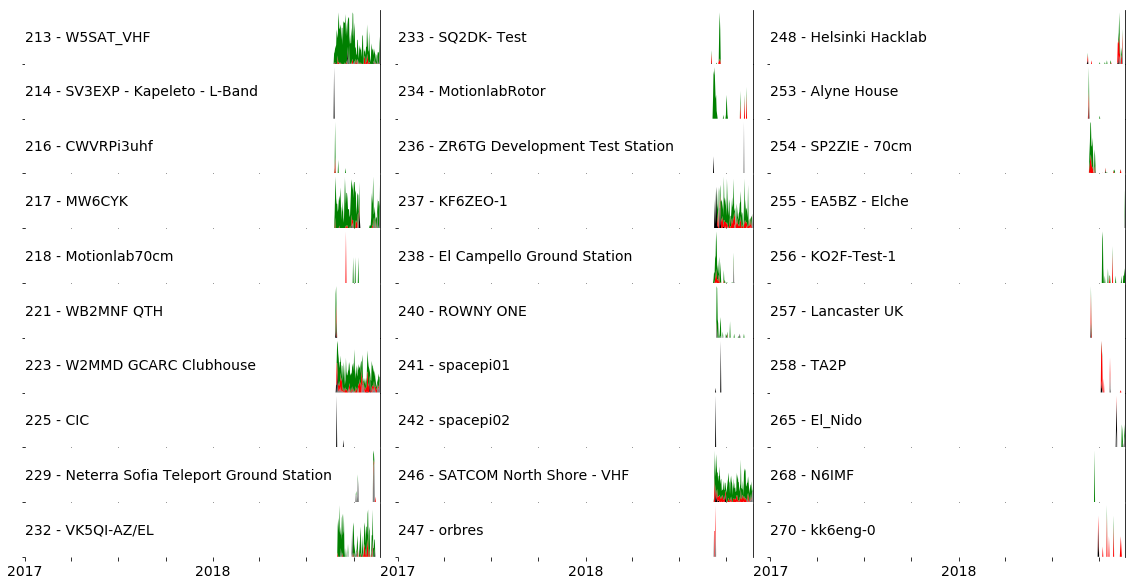

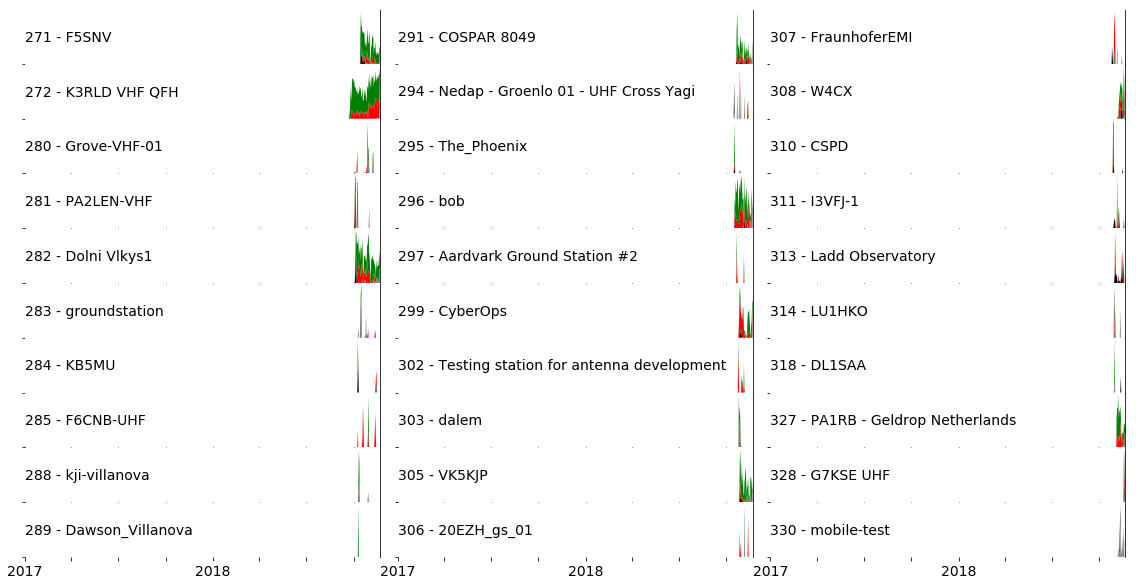

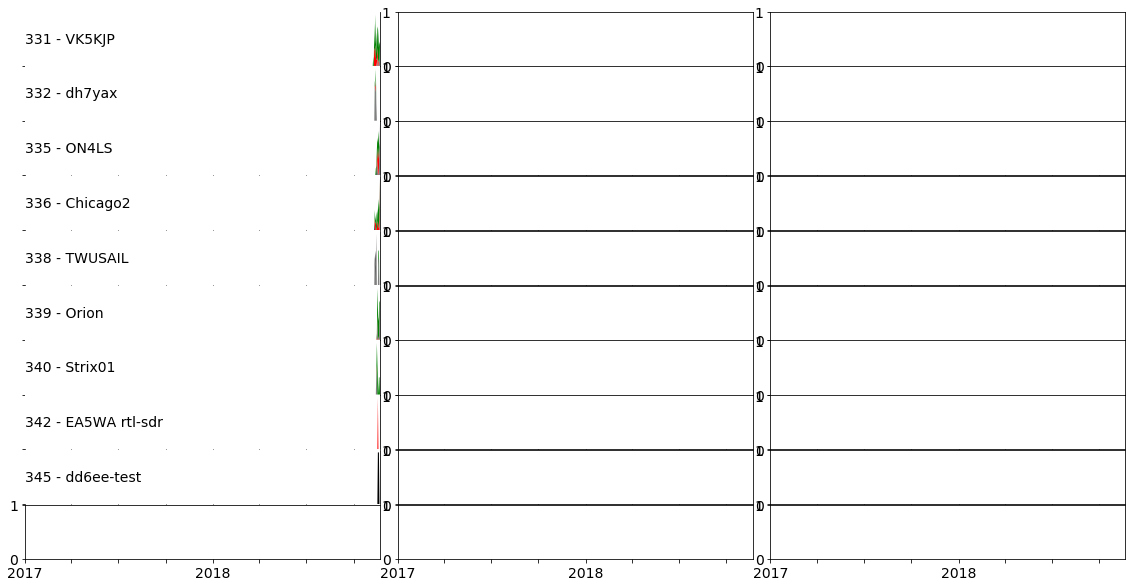

In [15]:

nrows = 10
ncols = 3
nsubplots = nrows * ncols

fig = None
for i, gsid in enumerate(sorted(gstree)):
    if (i % nsubplots) == 0:
        if fig:
            fig.tight_layout()
            fig.subplots_adjust(hspace=0.01, wspace=0.05, top=0.9)
            #fig.suptitle('Individual station passes', fontsize=40)
            fig.savefig('stations-%i' % ((i-1)//nsubplots))
        fig, axs = plt.subplots(nrows, ncols, figsize=(16, 9), sharex=True)
    
    gs = gstree[gsid]
   
    ax = axs.T.flat[i % nsubplots]
    t = ax.set_title(
        '%i - %s' % (gs.id, gs.gsname),
        va='top',
        pad=-20,
        loc='left',
        fontsize='medium', 
    )
    t.set_bbox(dict(facecolor='white', edgecolor='white', alpha=0.7))
    
    plot_status(gs, ax)

    #break
plt.tight_layout()
fig.subplots_adjust(hspace=0.01, wspace=0.05, top=0.9)
#fig.suptitle('Individual station passes', fontsize=40)
i

In [16]:
len(gstree)

219